In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# Dataset root
DATASET_ROOT = "/content/drive/My Drive/Goslar_dataset_split"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "val")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 25
NUM_CLASSES = 4
SEED = 42


In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,

    rotation_range=10,         # Slight rotation
    width_shift_range=0.1,     # Minimal horizontal shift
    height_shift_range=0.1,    # Minimal vertical shift
    horizontal_flip=True,      # Flips image (remove if direction matters, e.g., text)
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator( preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)



Found 1920 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [ ]:
from tensorflow.keras import layers, models
from keras.regularizers import l2
import tensorflow


# 1. Load pre-trained ResNet50V2 without the top head
# input_shape=(128, 128, 3) fits your data perfectly
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# 2. Freeze the base model to prevent overfitting on your small dataset
base_model.trainable = False

# 3. Build the final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Flattens the 4D output to 2D
    #layers.BatchNormalization(),      # Adds stability for small training sets
    layers.Dropout(0.5),              # Heavily reduces overfitting
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    #layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax') # Replace 10 with your class count
])

# 4. Compile with a standard optimizer
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy', # Use 'categorical_crossentropy' if labels are one-hot
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        "best_model_phase1.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2979 - loss: 2.7413
Epoch 1: val_loss improved from inf to 1.69809, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.2995 - loss: 2.7280 - val_accuracy: 0.4292 - val_loss: 1.6981 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4130 - loss: 1.7915
Epoch 2: val_loss improved from 1.69809 to 1.54305, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.4140 - loss: 1.7877 - val_accuracy: 0.4917 - val_loss: 1.5430 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4578 - loss: 1.5825
Epoch 3: val_loss improved from 1.54305 to 1.54135, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.4580 - loss: 1.5822 - val_accuracy: 0.4917 - val_loss: 1.5413 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4687 - loss: 1.4846
Epoch 4: val_loss improved from 1.54135 to 1.52009, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.4694 - loss: 1.4842 - val_accuracy: 0.4667 - val_loss: 1.5201 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5333 - loss: 1.4052
Epoch 5: val_loss improved from 1.52009 to 1.47489, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.5331 - loss: 1.4055 - val_accuracy: 0.5292 - val_loss: 1.4749 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5294 - loss: 1.3786
Epoch 6: val_loss improved from 1.47489 to 1.46876, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.5291 - loss: 1.3794 - val_accuracy: 0.5083 - val_loss: 1.4688 - learning_rate: 0.0010
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5585 - loss: 1.3549
Epoch 7: val_loss did not improve from 1.46876
30/30 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.5580 - loss: 1.3553 - val_accuracy: 0.4875 - val_loss: 1.4730 - learning_rate: 0.0010
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5753 - loss: 1.3286
Epoch 8: val_loss improved from 1.46876 to 1.45658, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.5752 - loss: 1.3284 - val_accuracy: 0.5208 - val_loss: 1.4566 - learning_rate: 0.0010
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5428 - loss: 1.3208
Epoch 9: val_loss improved from 1.45658 to 1.43562, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.5428 - loss: 1.3209 - val_accuracy: 0.4875 - val_loss: 1.4356 - learning_rate: 0.0010
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5729 - loss: 1.2904
Epoch 10: val_loss did not improve from 1.43562
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.5728 - loss: 1.2905 - val_accuracy: 0.5000 - val_loss: 1.4363 - learning_rate: 0.0010
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5707 - loss: 1.2799
Epoch 11: val_loss did not improve from 1.43562
30/30 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.5707 - loss: 1.2797 - val_accuracy: 0.5208 - val_loss: 1.4375 - learning_rate: 0.0010
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5845 - loss: 1.2540
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 12: val_loss did not improve from 1.43562
30/30 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.5846 - loss: 1.2539 - val_accuracy: 0.5125 - val_los

30/30 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.5845 - loss: 1.2971 - val_accuracy: 0.5375 - val_loss: 1.4072 - learning_rate: 3.0000e-04
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5868 - loss: 1.2251
Epoch 14: val_loss improved from 1.40717 to 1.40015, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.5874 - loss: 1.2247 - val_accuracy: 0.5333 - val_loss: 1.4001 - learning_rate: 3.0000e-04
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6118 - loss: 1.2122
Epoch 15: val_loss did not improve from 1.40015
30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.6116 - loss: 1.2119 - val_accuracy: 0.5333 - val_loss: 1.4134 - learning_rate: 3.0000e-04
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5895 - loss: 1.2194
Epoch 16: val_loss did not improve from 1.40015
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.5900 - loss: 1.2190 - val_accuracy: 0.5417 - val_loss: 1.4062 - learning_rate: 3.0000e-04
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6001 - loss: 1.2028
Epoch 17: val_loss improved from 1.40015 to 1.39904, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.6005 - loss: 1.2023 - val_accuracy: 0.5583 - val_loss: 1.3990 - learning_rate: 3.0000e-04
Epoch 18/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6029 - loss: 1.1831
Epoch 18: val_loss did not improve from 1.39904
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.6031 - loss: 1.1825 - val_accuracy: 0.5375 - val_loss: 1.4142 - learning_rate: 3.0000e-04
Epoch 19/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5987 - loss: 1.1773
Epoch 19: val_loss did not improve from 1.39904
30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.5990 - loss: 1.1772 - val_accuracy: 0.5625 - val_loss: 1.4019 - learning_rate: 3.0000e-04
Epoch 20/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6314 - loss: 1.1444
Epoch 20: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 20: val_loss did not improve from 1.39904
30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.6305 - loss: 1.1458 - val_accuracy: 0.55

30/30 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.6167 - loss: 1.1652 - val_accuracy: 0.5458 - val_loss: 1.3951 - learning_rate: 9.0000e-05
Epoch 22/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6181 - loss: 1.1466
Epoch 22: val_loss improved from 1.39505 to 1.39369, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.6179 - loss: 1.1467 - val_accuracy: 0.5417 - val_loss: 1.3937 - learning_rate: 9.0000e-05
Epoch 23/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6369 - loss: 1.1360
Epoch 23: val_loss improved from 1.39369 to 1.38098, saving model to best_model_phase1.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.6363 - loss: 1.1361 - val_accuracy: 0.5417 - val_loss: 1.3810 - learning_rate: 9.0000e-05
Epoch 24/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6602 - loss: 1.1131
Epoch 24: val_loss did not improve from 1.38098
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.6597 - loss: 1.1137 - val_accuracy: 0.5417 - val_loss: 1.3896 - learning_rate: 9.0000e-05
Epoch 25/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6188 - loss: 1.1272
Epoch 25: val_loss did not improve from 1.38098
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.6190 - loss: 1.1274 - val_accuracy: 0.5625 - val_loss: 1.3837 - learning_rate: 9.0000e-05
Epoch 26/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6075 - loss: 1.1641
Epoch 26: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 26: val_loss did not improve from 1.38098
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.6080 - loss: 1.1636 - val_accuracy: 0.55

In [ ]:
def graph(history):
  import matplotlib.pyplot as plt
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  nepochs=len(history.history['loss'])
  plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
  plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='validation')
  plt.legend(prop={'size': 20})
  plt.ylabel('loss')
  plt.xlabel('# of epochs')
  plt.subplot(1,2,2)
  plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
  plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='validation')
  plt.legend(prop={'size': 20})
  plt.ylabel('accuracy')
  plt.xlabel('# of epochs')

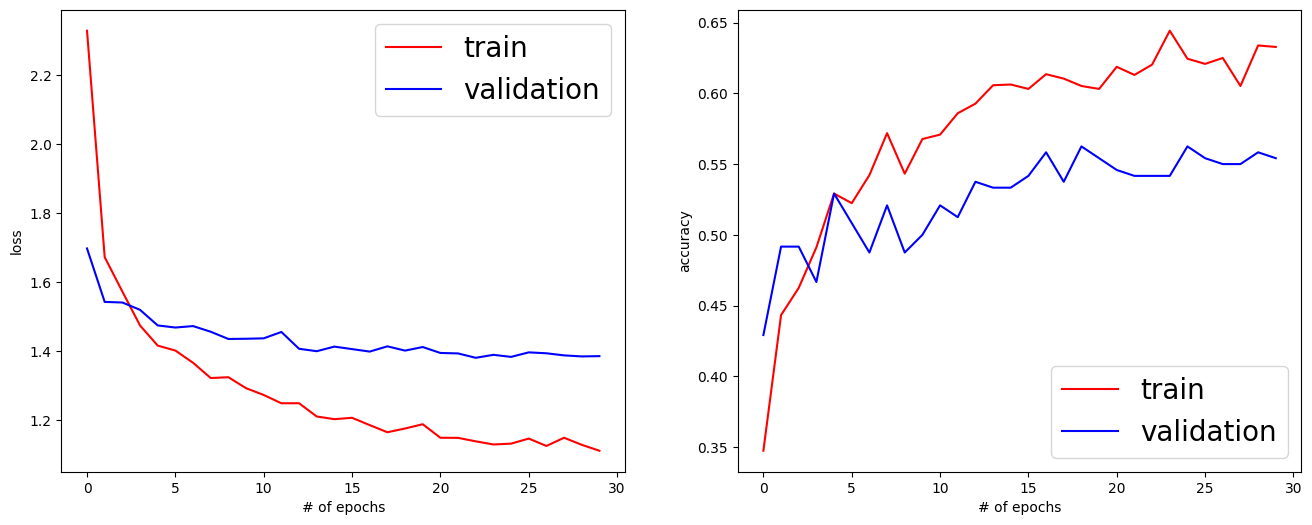

In [ ]:
graph(history_phase1)